# Tensorflow2 KeyNotes
### ==== Time Series Forechasting with Neural Networks (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate the time series forecasting by using variant neural network architectures, the results derived from different neural networks are quantitatively compared. The following contents are included in this notebook:

1. Time series forecasting by using a dense neural network.
2. Time series forecasting by using a simple recurrent neural network.
3. Time series forecasting by using a deep recurrent neural network. 
4. Time series forecasting by using a deep convolutional neural network.

### Code by Hao, Zhao, Aug, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack
import time

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten


### Generate a synthetic time series based on sinusoid signals



In [3]:
dt,t_min,t_max = 0.001,0,20 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2       = 30,100,200
SNR            = 20       
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t)  
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))


### Plot the generated time series

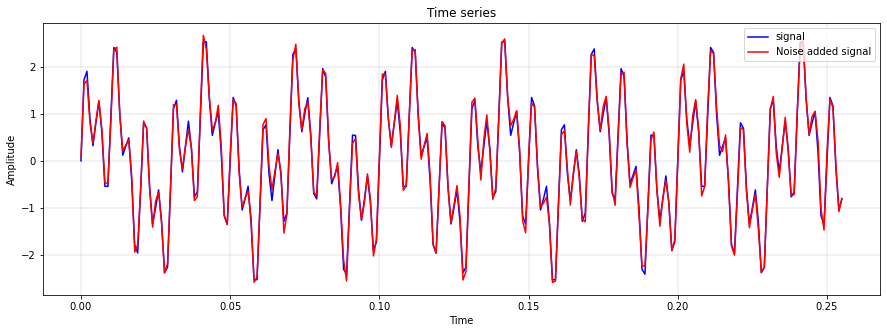

In [4]:

#set the samples to display
N=256

plt.figure(0,figsize=(15, 5))
plt.plot(t[0:N],syn_sig[0:N],'b',label='signal')
plt.plot(t[0:N],syn_data[0:N],'r',label='Noise added signal') 
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Time series')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Dataset preprocessing to generate the training and testing datasets

In [5]:

# define the function for datasets generation 

def dataset_generation(time_series,batch_size,window_step,predict_step):
    
    # derive the total batch numbers
    n_batch = ((len(t))-batch_size)//window_step + 1
    
    # derive the datasets: input (x) and tartget (y)
    dataset_x     = []
    dataset_y     = []    
    train_set_x   = []
    train_set_y   = []
    test_set_x    = []
    test_set_y    = []
    
    # loop through the time series and gernerate the data
    for n in np.arange(1,n_batch+1):
        
        data_batch = time_series[(0+(n-1)*window_step):(batch_size+(n-1)*window_step)] 
        data_x     = data_batch[0:batch_size-predict_step]
        data_y     = data_batch[batch_size-predict_step:batch_size]
    
        dataset_x  = np.concatenate((dataset_x, data_x))
        dataset_y  = np.concatenate((dataset_y, data_y))
        
    # reshape datasets to 2d dimension: batch x dataset
    dataset_x = np.reshape(dataset_x, newshape=(n_batch,len(data_x)))
    dataset_y = np.reshape(dataset_y, newshape=(n_batch,len(data_y)))
    
    # split the dataset into train 80% and test sets (20%)
    train_samples  = int(len(dataset_x) * 0.8) 

    train_set_x = dataset_x[:train_samples,:]
    train_set_y = dataset_y[:train_samples,:]

    test_set_x  = dataset_x[train_samples:,:]
    test_set_y  = dataset_y[train_samples:,:] 
        
    return train_set_x,train_set_y,test_set_x,test_set_y
    

# generate the datasets 
batch_size   = 256
window_step  = batch_size//8
predict_step = 10

train_set_x,train_set_y,test_set_x,test_set_y = dataset_generation(syn_data,batch_size,window_step,predict_step)

print('train_set_x: has shape {}'.format(train_set_x.shape))
print('train_set_y: has shape {}'.format(train_set_y.shape))
print('test_set_x: has shape {}'.format(test_set_x.shape))
print('test_set_y: has shape {}'.format(test_set_y.shape))



train_set_x: has shape (494, 246)
train_set_y: has shape (494, 10)
test_set_x: has shape (124, 246)
test_set_y: has shape (124, 10)


----------------------------------------------------------------------
## Method-1: Dense neural network 
----------------------------------------------------------------------


 ### Build the neural network 

In [6]:
model = Sequential([Dense(32, activation='relu',input_shape=(batch_size-predict_step,)),
                    Dropout(0.1),
                    Dense(16,activation='relu'),
                    Dropout(0.1),
                    Dense(predict_step)
                    ])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                7904      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                170       
Total params: 8,602
Trainable params: 8,602
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [7]:
start      = time.time()
history    = model.fit(train_set_x,train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Epoch 1/100
14/14 [==============================] - 0s 9ms/step - loss: 1.5304 - mae: 0.9825 - val_loss: 0.9535 - val_mae: 0.7824
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.9802 - mae: 0.7917 - val_loss: 0.7690 - val_mae: 0.6975
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.8347 - mae: 0.7287 - val_loss: 0.6259 - val_mae: 0.6346
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.7353 - mae: 0.6757 - val_loss: 0.5076 - val_mae: 0.5688
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6537 - mae: 0.6303 - val_loss: 0.4056 - val_mae: 0.5023
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5761 - mae: 0.5864 - val_loss: 0.3541 - val_mae: 0.4588
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5951 - mae: 0.5921 - val_loss: 0.3340 - val_mae: 0.4465
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5015 - m

Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1612 - mae: 0.2883 - val_loss: 0.0442 - val_mae: 0.1677
Epoch 64/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1590 - mae: 0.2880 - val_loss: 0.0483 - val_mae: 0.1726
Epoch 65/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1626 - mae: 0.2952 - val_loss: 0.0385 - val_mae: 0.1536
Epoch 66/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1666 - mae: 0.2930 - val_loss: 0.0482 - val_mae: 0.1717
Epoch 67/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1535 - mae: 0.2859 - val_loss: 0.0444 - val_mae: 0.1692
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1471 - mae: 0.2760 - val_loss: 0.0408 - val_mae: 0.1608
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1593 - mae: 0.2890 - val_loss: 0.0384 - val_mae: 0.1568
Epoch 70/100
14/14 [==============================] - 0s 3ms/step - loss: 0.

### Display of training and validation losses in the network training


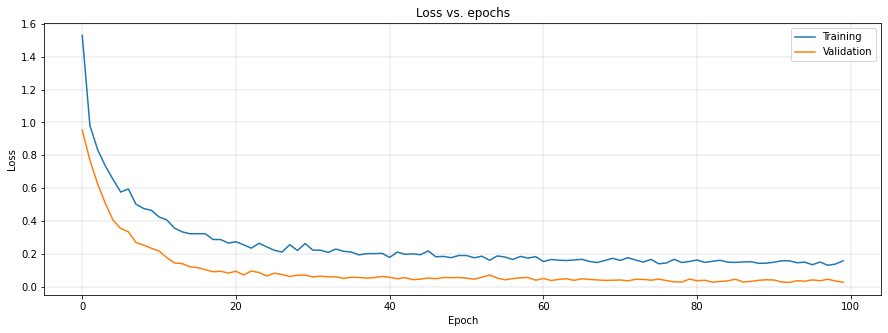

In [8]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned dense neural network


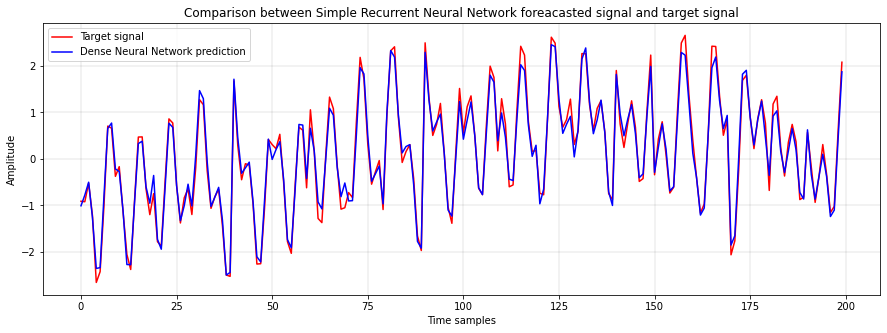

Neural network SNR: 17.70095649485478
Mean Square Error: 0.025547720759908972


In [9]:
dnn_predictions = model.predict(test_set_x)
dnn_err         = dnn_predictions - test_set_y

plt.figure(3,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(dnn_predictions[:20,:].flatten(),'b',label='Dense Neural Network prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

dnn_mse    = 10*np.log10(np.mean(pow(np.abs(dnn_err),2)))
dnn_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Neural network SNR:", dnn_sigpow - dnn_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)))



----------------------------------------------------------------------
## Method-2: Simple recurrent neural network 
----------------------------------------------------------------------


 ### Build a simple recurrent neural network

In [10]:
model_simple_rnn = Sequential([SimpleRNN(predict_step,input_shape=[batch_size-predict_step,1])])

model_simple_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])

model_simple_rnn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [11]:
start      = time.time()
history    = model_simple_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Epoch 1/100
14/14 [==============================] - 1s 84ms/step - loss: 1.6900 - mae: 1.0559 - val_loss: 1.6535 - val_mae: 1.0521
Epoch 2/100
14/14 [==============================] - 1s 81ms/step - loss: 1.6112 - mae: 1.0314 - val_loss: 1.5941 - val_mae: 1.0324
Epoch 3/100
14/14 [==============================] - 1s 79ms/step - loss: 1.5594 - mae: 1.0145 - val_loss: 1.5500 - val_mae: 1.0184
Epoch 4/100
14/14 [==============================] - 1s 78ms/step - loss: 1.5173 - mae: 1.0009 - val_loss: 1.5105 - val_mae: 1.0061
Epoch 5/100
14/14 [==============================] - 1s 81ms/step - loss: 1.4763 - mae: 0.9877 - val_loss: 1.4698 - val_mae: 0.9934
Epoch 6/100
14/14 [==============================] - 1s 83ms/step - loss: 1.4339 - mae: 0.9741 - val_loss: 1.4277 - val_mae: 0.9785
Epoch 7/100
14/14 [==============================] - 1s 81ms/step - loss: 1.3920 - mae: 0.9584 - val_loss: 1.3883 - val_mae: 0.9642
Epoch 8/100
14/14 [==============================] - 1s 81ms/step - loss: 1.

14/14 [==============================] - 1s 78ms/step - loss: 0.7591 - mae: 0.6990 - val_loss: 0.7610 - val_mae: 0.7027
Epoch 63/100
14/14 [==============================] - 1s 79ms/step - loss: 0.7533 - mae: 0.6957 - val_loss: 0.7535 - val_mae: 0.6971
Epoch 64/100
14/14 [==============================] - 1s 81ms/step - loss: 0.7494 - mae: 0.6941 - val_loss: 0.7488 - val_mae: 0.6944
Epoch 65/100
14/14 [==============================] - 1s 80ms/step - loss: 0.7448 - mae: 0.6921 - val_loss: 0.7438 - val_mae: 0.6920
Epoch 66/100
14/14 [==============================] - 1s 80ms/step - loss: 0.7408 - mae: 0.6900 - val_loss: 0.7421 - val_mae: 0.6924
Epoch 67/100
14/14 [==============================] - 1s 83ms/step - loss: 0.7336 - mae: 0.6863 - val_loss: 0.7369 - val_mae: 0.6901
Epoch 68/100
14/14 [==============================] - 1s 79ms/step - loss: 0.7314 - mae: 0.6847 - val_loss: 0.7337 - val_mae: 0.6894
Epoch 69/100
14/14 [==============================] - 1s 79ms/step - loss: 0.7257 

### Display of training and validation losses in the network training

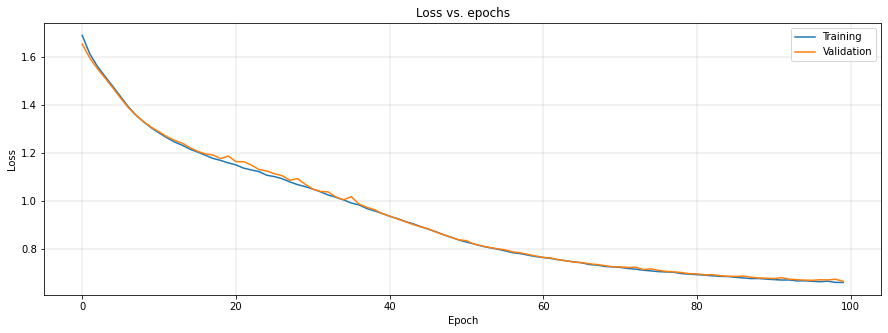

In [12]:
plt.figure(4,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

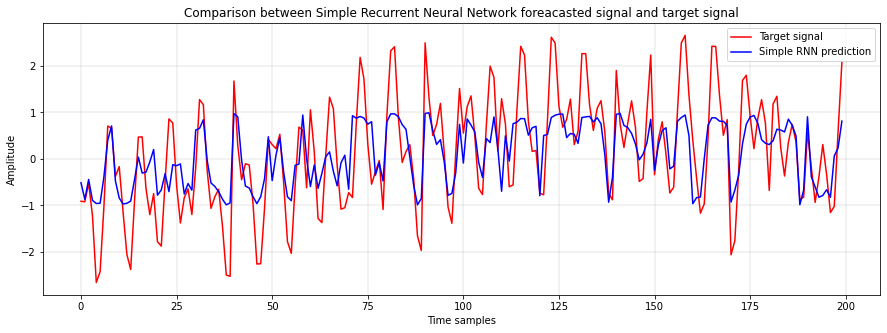

Simple Recurrent Neural network's SNR: 3.5558784404453174
Mean Square Error: 0.6635290875365566


In [13]:
simple_RNN_predictions = model_simple_rnn.predict(test_set_x[...,np.newaxis])
simple_RNN_err         = simple_RNN_predictions - test_set_y

plt.figure(5,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(simple_RNN_predictions[:20,:].flatten(),'b',label='Simple RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Simple Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

simple_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(simple_RNN_err),2)))
simple_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Simple Recurrent Neural network's SNR:", simple_RNN_sigpow - simple_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(simple_RNN_predictions,test_set_y)))

----------------------------------------------------------------------
## Method-3: Deep recurrent neural network 
----------------------------------------------------------------------


 ### Build a Deep recurrent neural network

In [14]:
model_deep_rnn = Sequential([SimpleRNN(20,input_shape=[batch_size-predict_step,1],return_sequences=True),
                             # SimpleRNN(20,return_sequences=True),
                             # SimpleRNN(predict_step),
                             SimpleRNN(20,return_sequences=False),
                             Dense(predict_step)
                             ])

model_deep_rnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 246, 20)           440       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [15]:
start      = time.time()
history    = model_deep_rnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Epoch 1/100
14/14 [==============================] - 2s 174ms/step - loss: 1.2499 - mae: 0.9093 - val_loss: 1.0431 - val_mae: 0.8315
Epoch 2/100
14/14 [==============================] - 2s 155ms/step - loss: 0.9262 - mae: 0.7785 - val_loss: 0.8191 - val_mae: 0.7343
Epoch 3/100
14/14 [==============================] - 2s 159ms/step - loss: 0.7273 - mae: 0.6856 - val_loss: 0.6433 - val_mae: 0.6463
Epoch 4/100
14/14 [==============================] - 2s 160ms/step - loss: 0.5696 - mae: 0.6060 - val_loss: 0.5040 - val_mae: 0.5725
Epoch 5/100
14/14 [==============================] - 2s 159ms/step - loss: 0.4444 - mae: 0.5347 - val_loss: 0.3950 - val_mae: 0.5065
Epoch 6/100
14/14 [==============================] - 2s 158ms/step - loss: 0.3474 - mae: 0.4713 - val_loss: 0.3164 - val_mae: 0.4514
Epoch 7/100
14/14 [==============================] - 2s 157ms/step - loss: 0.2715 - mae: 0.4144 - val_loss: 0.2404 - val_mae: 0.3929
Epoch 8/100
14/14 [==============================] - 2s 153ms/step - 

14/14 [==============================] - 2s 161ms/step - loss: 0.0185 - mae: 0.1071 - val_loss: 0.0248 - val_mae: 0.1269
Epoch 63/100
14/14 [==============================] - ETA: 0s - loss: 0.0176 - mae: 0.105 - 2s 158ms/step - loss: 0.0176 - mae: 0.1054 - val_loss: 0.0222 - val_mae: 0.1202
Epoch 64/100
14/14 [==============================] - 2s 157ms/step - loss: 0.0174 - mae: 0.1055 - val_loss: 0.0164 - val_mae: 0.1041
Epoch 65/100
14/14 [==============================] - 2s 163ms/step - loss: 0.0177 - mae: 0.1057 - val_loss: 0.0166 - val_mae: 0.1046
Epoch 66/100
14/14 [==============================] - 2s 163ms/step - loss: 0.0177 - mae: 0.1064 - val_loss: 0.0190 - val_mae: 0.1104
Epoch 67/100
14/14 [==============================] - 2s 159ms/step - loss: 0.0178 - mae: 0.1063 - val_loss: 0.0218 - val_mae: 0.1200
Epoch 68/100
14/14 [==============================] - 2s 158ms/step - loss: 0.0164 - mae: 0.1023 - val_loss: 0.0195 - val_mae: 0.1138
Epoch 69/100
14/14 [=================

### Display of training and validation losses in the network training

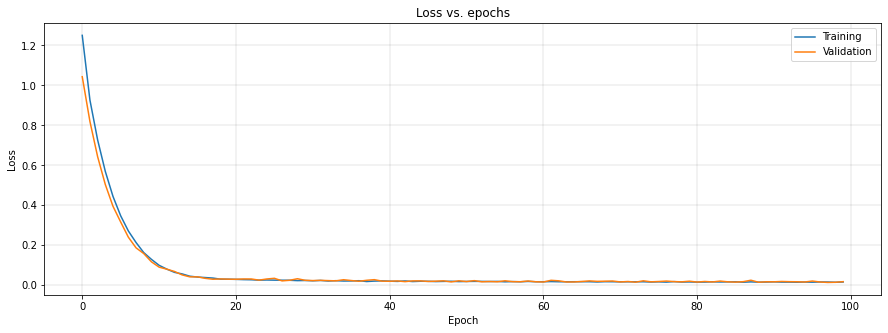

In [16]:
plt.figure(6,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


### Time series forecasting with trainned neural network

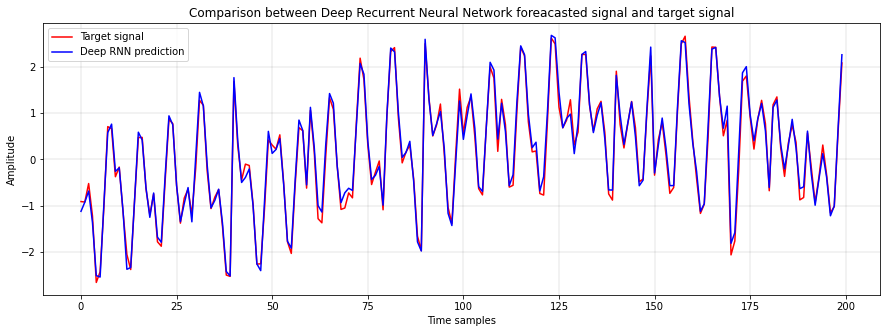

Deep Recurrent Neural network's SNR: 19.100220549540513
Mean Square Error: 0.018510824151818765


In [17]:
deep_RNN_predictions = model_deep_rnn.predict(test_set_x[...,np.newaxis])
deep_RNN_err         = deep_RNN_predictions - test_set_y

plt.figure(7,figsize=(15, 5))

plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_RNN_predictions[:20,:].flatten(),'b',label='Deep RNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep Recurrent Neural Network foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_RNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_RNN_err),2)))
deep_RNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_RNN_sigpow - deep_RNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_RNN_predictions,test_set_y)))


----------------------------------------------------------------------
## Method-4: Deep convolutional neural network 
----------------------------------------------------------------------


 ### Build a Deep convolutional neural network

In [18]:
model_deep_cnn = Sequential([Conv1D(filters=5, kernel_size=4, activation='tanh',input_shape=[batch_size-predict_step,1]),
                             AveragePooling1D(pool_size=4),
                             Flatten(),
                             Dense(16, activation='relu'),
                             Dense(predict_step)
                             ])

model_deep_cnn.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='mse',metrics=['mae'])
model_deep_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 243, 5)            25        
_________________________________________________________________
average_pooling1d (AveragePo (None, 60, 5)             0         
_________________________________________________________________
flatten (Flatten)            (None, 300)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                4816      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                170       
Total params: 5,011
Trainable params: 5,011
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [19]:
start      = time.time()
history    = model_deep_cnn.fit(train_set_x[...,np.newaxis],train_set_y,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Epoch 1/100
14/14 [==============================] - 0s 9ms/step - loss: 1.2419 - mae: 0.9100 - val_loss: 0.9047 - val_mae: 0.7830
Epoch 2/100
14/14 [==============================] - 0s 3ms/step - loss: 0.7860 - mae: 0.7240 - val_loss: 0.6762 - val_mae: 0.6636
Epoch 3/100
14/14 [==============================] - 0s 3ms/step - loss: 0.6130 - mae: 0.6305 - val_loss: 0.5491 - val_mae: 0.5951
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.5076 - mae: 0.5694 - val_loss: 0.4573 - val_mae: 0.5414
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.4235 - mae: 0.5224 - val_loss: 0.3856 - val_mae: 0.4962
Epoch 6/100
14/14 [==============================] - 0s 3ms/step - loss: 0.3537 - mae: 0.4768 - val_loss: 0.3154 - val_mae: 0.4504
Epoch 7/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2856 - mae: 0.4294 - val_loss: 0.2480 - val_mae: 0.4032
Epoch 8/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2268 - m

Epoch 63/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0142 - mae: 0.0950 - val_loss: 0.0147 - val_mae: 0.0979
Epoch 64/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0137 - mae: 0.0939 - val_loss: 0.0156 - val_mae: 0.1010
Epoch 65/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0139 - mae: 0.0943 - val_loss: 0.0152 - val_mae: 0.0999
Epoch 66/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0147 - mae: 0.0967 - val_loss: 0.0158 - val_mae: 0.1007
Epoch 67/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0142 - mae: 0.0953 - val_loss: 0.0155 - val_mae: 0.0985
Epoch 68/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0139 - mae: 0.0943 - val_loss: 0.0179 - val_mae: 0.1074
Epoch 69/100
14/14 [==============================] - 0s 3ms/step - loss: 0.0143 - mae: 0.0953 - val_loss: 0.0131 - val_mae: 0.0937
Epoch 70/100
14/14 [==============================] - 0s 3ms/step - loss: 0.

### Display of training and validation losses in the network training

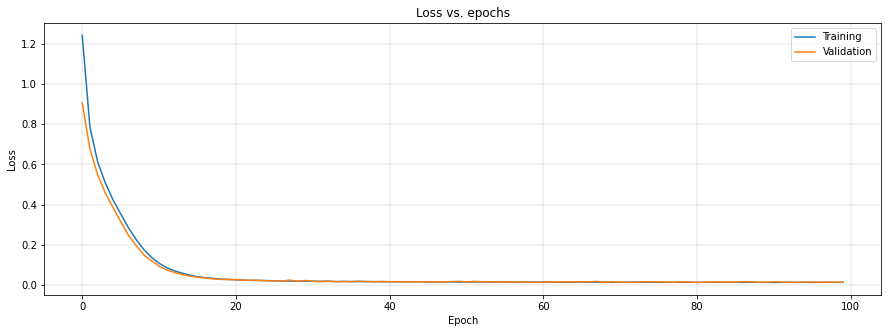

In [20]:
plt.figure(8,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Time series forecasting with trainned neural network

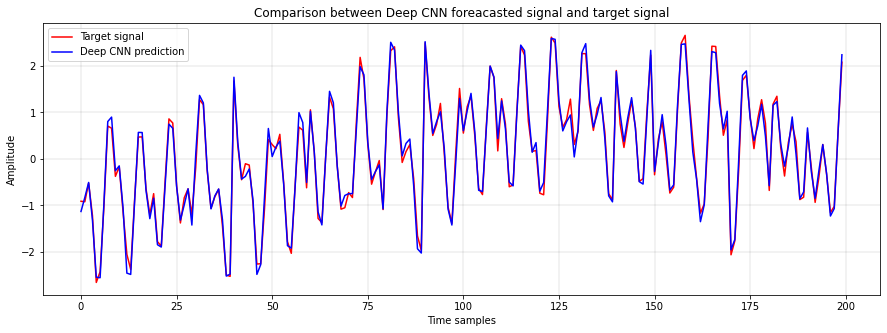

Deep Recurrent Neural network's SNR: 19.989988021156048
Mean Square Error: 0.015081655212167776


In [21]:
deep_CNN_predictions = model_deep_cnn.predict(test_set_x[...,np.newaxis])
deep_CNN_err         = deep_CNN_predictions - test_set_y

plt.figure(9,figsize=(15, 5))
plt.plot(test_set_y[:20,:].flatten(),'r',label='Target signal')
plt.plot(deep_CNN_predictions[:20,:].flatten(),'b',label='Deep CNN prediction')
plt.xlabel('Time samples')
plt.ylabel('Amplitude')
plt.title('Comparison between Deep CNN foreacasted signal and target signal')
plt.legend()
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

deep_CNN_mse    = 10*np.log10(np.mean(pow(np.abs(deep_CNN_err),2)))
deep_CNN_sigpow = 10*np.log10(np.mean(pow(np.abs(test_set_y),2)))

print("Deep Recurrent Neural network's SNR:", deep_CNN_sigpow - deep_CNN_mse)
print("Mean Square Error:", np.mean(tf.keras.losses.mean_squared_error(deep_CNN_predictions,test_set_y)))

----------------------------------------------------------------------
## Summary:  Comparison of methods
----------------------------------------------------------------------



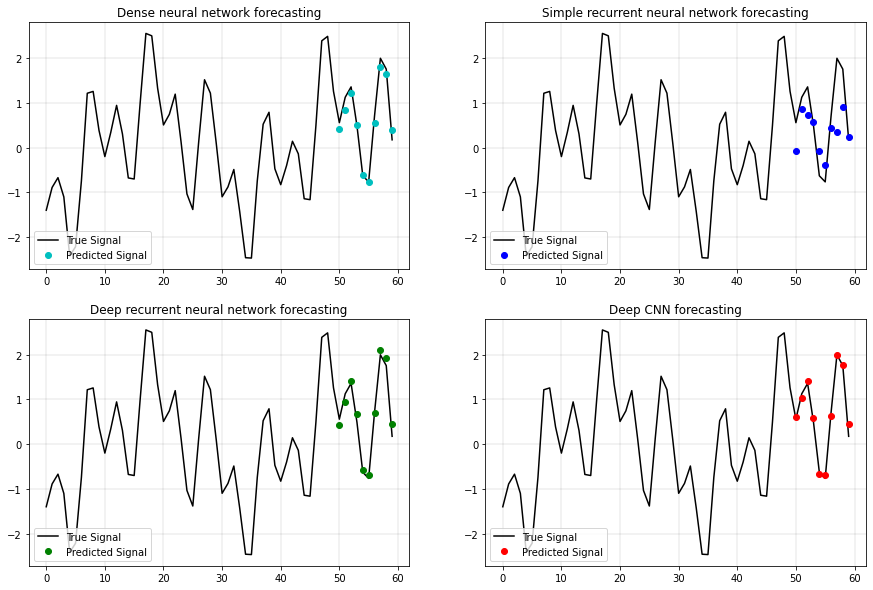

In [22]:
plt.figure(9,figsize=(15, 10))

plt.subplot(221)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],dnn_predictions[10,:]),axis=0),'co',label='Predicted Signal')
plt.title('Dense neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')

plt.subplot(222)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],simple_RNN_predictions[10,:]),axis=0),'bo',label='Predicted Signal')
plt.title('Simple recurrent neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')


plt.subplot(223)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],deep_RNN_predictions[10,:]),axis=0),'go',label='Predicted Signal')
plt.title('Deep recurrent neural network forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')

plt.subplot(224)
plt.plot(np.concatenate((test_set_x[10,-50:],test_set_y[10,:]),axis=0),'k',label='True Signal')
plt.plot(np.concatenate((len(test_set_x[10,-50:])*[None],deep_CNN_predictions[10,:]),axis=0),'ro',label='Predicted Signal')
plt.title('Deep CNN forecasting')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')


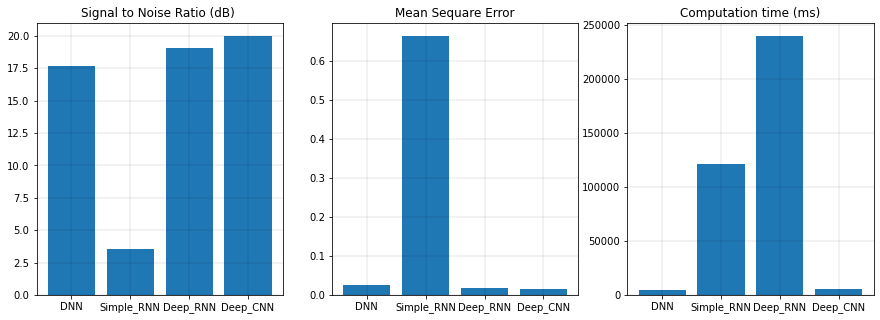

In [23]:
names = ['DNN', 'Simple_RNN', 'Deep_RNN','Deep_CNN']
SNR   = [dnn_sigpow - dnn_mse, simple_RNN_sigpow - simple_RNN_mse,deep_RNN_sigpow - deep_RNN_mse, deep_CNN_sigpow - deep_CNN_mse]
MSE   = [np.mean(tf.keras.losses.mean_squared_error(dnn_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(simple_RNN_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(deep_RNN_predictions,test_set_y)),np.mean(tf.keras.losses.mean_squared_error(deep_CNN_predictions,test_set_y))]
Time  = [4682.42,121381.42,239705.38,5380.72]


plt.figure(10,figsize=(15, 5))
plt.subplot(131)
plt.bar(names, SNR)
plt.title('Signal to Noise Ratio (dB) ')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(132)
plt.bar(names, MSE)
plt.title('Mean Sequare Error')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(133)
plt.bar(names, Time)
plt.title('Computation time (ms)')
# plt.suptitle('Comparison of Performance')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()


By comparing the prediction results obtained from these 4 different neural network architectures, you can see the Deep recurrent neural network (RNN) and deep convolutional neural network (CNN) gives the highest signal to noise ratios as well as the least mean square errors. If we further compare the computational cost of deep RNN and deep CNN, we can see later network structure requires much less computation cost compared to the Deep RNN architecture. Thus I would recommend using deep convolutional neural networks among the proposed neural network architectures for 1D time series forecasting.  To further evaluate the neural network-based time series forecasting methods, further experiments will need to be tested against traditional parametric or non-parametric methods such as the moving-average (MA) model and autoregressive integrated moving average (ARIMA) model methods.

### Reference

- Geron, Aurelien, Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow
- Time series forecasting, Tensorflow 2 Tutorials.